read dicom

In [5]:
import numpy as np
import skimage.measure
import pydicom
import vtk
from vtk.util import numpy_support
import os
import matplotlib.pyplot as plt
import cv2

In [327]:
import gc
gc.collect()

20741

In [6]:
plt.gray()
os.chdir('C:/Users/span/Documents/3DSlicerTutorial/CNN.test/')
number1 = "23"

<Figure size 432x288 with 0 Axes>

In [7]:
PathDicom = "./"+str(number1)+"_5/"
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(PathDicom)
reader.Update()

# Load dimensions using `GetDataExtent`
_extent = reader.GetDataExtent()
ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]

# Load spacing values
ConstPixelSpacing = reader.GetPixelSpacing()

# Get the 'vtkImageData' object from the reader
imageData = reader.GetOutput()
# Get the 'vtkPointData' object from the 'vtkImageData' object
pointData = imageData.GetPointData()
# Ensure that only one array exists within the 'vtkPointData' object
assert (pointData.GetNumberOfArrays()==1)
# Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function
arrayData = pointData.GetArray(0)

# Convert the `vtkArray` to a NumPy array
ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
# Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'
ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')

a = ArrayDicom.copy()

In [ ]:
# output image
from PIL import Image
pathin = "./"+str(number1)+"_in/"
a1 = np.where(a <= -1000, -999, a) 
for i in range(a.shape[2]):
    image = a1[:, :, i].copy()
    I8_0 = (((image - a1.min()) / (a1.max() - a1.min())) * 255.9).astype(np.uint8)
    img0 = Image.fromarray(I8_0)
    img0.save(pathin+str(number1)+"_in_rec00000"+str("{0:03}".format(i))+".bmp")

Method 1: thicker edge and subtract

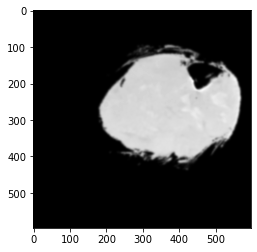

In [8]:
# Adaptive Thresholding
from skimage.filters import threshold_local

a = ArrayDicom.copy()
image = a[:, :, 381].copy()
plt.imshow(image)

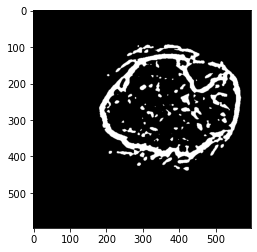

In [9]:
# local threshold 23_5 or 23_8
block_size = 23
binary_image1 = image > (threshold_local(image, block_size,offset=0, method='mean')+20)
plt.imshow(binary_image1)

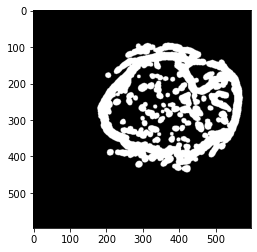

In [224]:
# close gap (blur/extend) 
from skimage import morphology
binary_image2 = morphology.dilation(binary_image1, morphology.disk(radius=5))
plt.imshow(binary_image2)

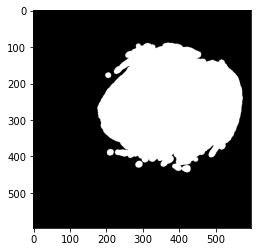

In [225]:
# fill holes
from scipy import ndimage as ndi
fill_coins = ndi.binary_fill_holes(binary_image2)
plt.imshow(fill_coins)

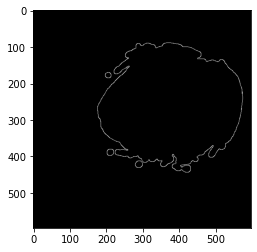

In [226]:
# edge
from skimage.feature import canny
binary_image3 = canny(fill_coins, sigma=1)
plt.imshow(binary_image3)

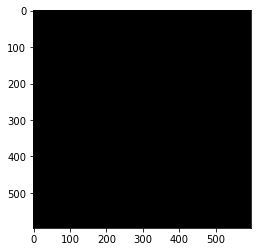

In [227]:
# edge on image
from skimage.feature import canny
binary_image3_1 = canny(image, sigma=1)
plt.imshow(binary_image3_1)

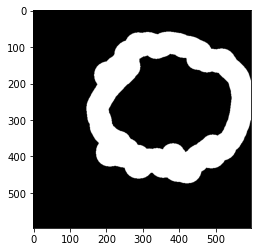

In [228]:
# thicker the edge
from skimage import morphology
binary_image4 = morphology.dilation(binary_image3, morphology.disk(radius=30))
plt.imshow(binary_image4)

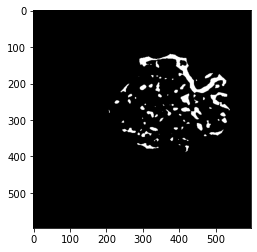

In [229]:
# remove the edge
binary_image5 = binary_image1 > binary_image4
plt.imshow(binary_image5)

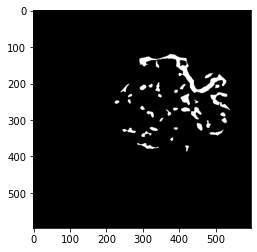

In [230]:
# remove small object
binary_image6 = morphology.remove_small_objects(binary_image5, 50)
plt.imshow(binary_image6)

In [83]:
# save image skimage
from skimage import io
rescaled = 255.0 * binary_image6.astype(np.uint8)
io.imsave('output.bmp', rescaled.astype(np.uint8))
io.imsave('image.bmp', image.astype(np.uint8))


<ipython-input-83-de2a0a637950>:4: UserWarning: output.bmp is a low contrast image
  io.imsave('output.bmp', rescaled.astype(np.uint8))


In [95]:
# save image PIL
from PIL import Image
# I8_0 = (((image - image.min()) / (image.max() - image.min())) * 255.9).astype(np.uint8)
I8_0 = (((image - a.min()) / (a.max() - a.min())) * 255.9).astype(np.uint8)
img0 = Image.fromarray(I8_0)
img0.save("23_in"+str("{0:03}".format(i))+".bmp")



I8_1 = (((binary_image6.astype(np.uint8) - binary_image6.astype(np.uint8).min()) / (binary_image6.astype(np.uint8).max() - binary_image6.astype(np.uint8).min())) * 255.9).astype(np.uint8)
img1 = Image.fromarray(I8_1)
img1.save("23_out"+str("{0:03}".format(i))+".bmp")



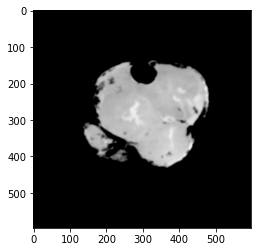

In [112]:
# for loop
from PIL import Image
pathout = "./"+str(number1)+"_out/"
result = np.empty([596, 596])
for i in range(a.shape[2]):
    image = a[:, :, i].copy()
    block_size = 23
    binary_image1 = image > (threshold_local(image, block_size,offset=0, method='mean')+20)
    binary_image2 = morphology.dilation(binary_image1, morphology.disk(radius=5))
    fill_coins = ndi.binary_fill_holes(binary_image2)
    binary_image3 = canny(fill_coins, sigma=1)
    binary_image4 = morphology.dilation(binary_image3, morphology.disk(radius=25))
    binary_image5 = binary_image1 > binary_image4
    binary_image6 = morphology.remove_small_objects(binary_image5, 21)
    I8_1 = (((binary_image6.astype(np.uint8) - binary_image6.astype(np.uint8).min()) / (binary_image6.astype(np.uint8).max() - binary_image6.astype(np.uint8).min())) * 255.9).astype(np.uint8)
    img1 = Image.fromarray(I8_1)
    img1.save(pathout+str(number1)+"_out_rec00000"+str("{0:03}".format(i))+".bmp")
    result = np.dstack((result, binary_image6))

result.shape

In [28]:
# out put vtr
from pyevtk.hl import gridToVTK

x = np.arange(0, result.shape[0]+1)
y = np.arange(0, result.shape[1]+1)
z = np.arange(0, result.shape[2]+1)

gridToVTK("./23_o", x, y, z, cellData = {'result': result})

'C:\\Users\\span\\Documents\\3DSlicerTutorial\\CNN.test\\23_o.vtr'

In [64]:
# write into text and load
# Write the array to disk
rescaled = 255.0 * result.astype(np.uint8)
with open('23_o_res_test.txt', 'w') as outfile:
    # I'm writing a header here just for the sake of readability
    # Any line starting with "#" will be ignored by numpy.loadtxt
    outfile.write('# Array shape: {0}\n'.format(rescaled.shape))
    
    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in rescaled:

        # The formatting string indicates that I'm writing out
        # the values in left-justified columns 7 characters in width
        # with 2 decimal places.  
        np.savetxt(outfile, data_slice, fmt='%-7.2f')

        # Writing out a break to indicate different slices...
        outfile.write('# New slice\n')

In [ ]:
# Read the array from disk
new_data = np.loadtxt('23_o_test.txt')
# 'C:/Users/span/Documents/3DSlicerTutorial/CNN.test/23_o_test.txt'
# Note that this returned a 2D array!
# print new_data.shape

# However, going back to 3D is easy if we know the 
# original shape of the array
new_data = new_data.reshape((596, 596, 563))
    
# Just to check that they're the same...
assert np.all(new_data == result)

Method 2: remove largest

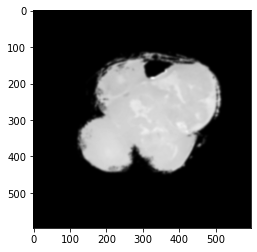

In [291]:
# assign image
a = ArrayDicom.copy()
image = a[:, :, 149].copy()
plt.imshow(image)

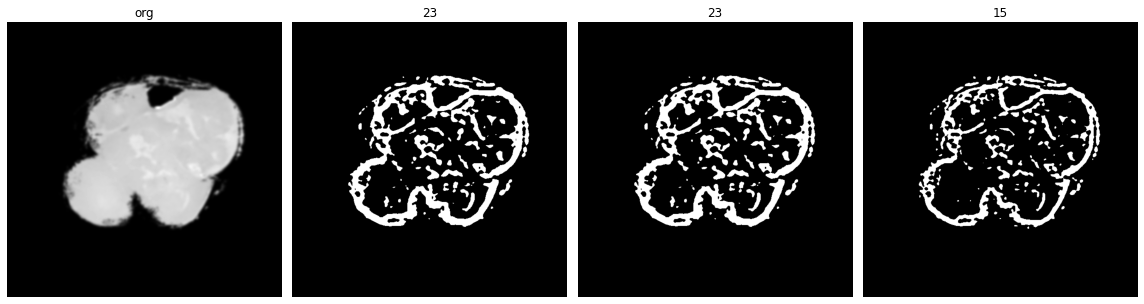

In [292]:
# Adaptive Thresholding
from skimage.filters import threshold_local
# local threshold 23_5 or 23_8
block_size = 23
binary_image1 = image > (threshold_local(image, block_size,offset=0, method='mean')+20)
block_size1 = 23
binary_image1_1 = image > (threshold_local(image, block_size1,offset=-20, method='mean')+0)
block_size2 = 15
binary_image1_2 = image > (threshold_local(image, block_size2,offset=0, method='mean')+20)

# plt.imshow(binary_image1)

#plot results
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 6.4),
                                    sharex=True, sharey=True)
ax0.imshow(image, cmap='gray')
ax0.axis('off')
ax0.set_title('org')
ax1.imshow(binary_image1, cmap='gray')
ax1.axis('off')
ax1.set_title(block_size)
ax2.imshow(binary_image1_1, cmap='gray') # 'magma'
ax2.axis('off')
ax2.set_title(block_size1)
ax3.imshow(binary_image1_2, cmap='gray')
ax3.axis('off')
ax3.set_title(block_size2)

fig.tight_layout()
plt.show()

<ipython-input-293-6003093e79a1>:12: RuntimeWarning: invalid value encountered in true_divide
  I8_1 = (((binary_image6.astype(np.uint8) - binary_image6.astype(np.uint8).min()) / (binary_image6.astype(np.uint8).max() - binary_image6.astype(np.uint8).min())) * 255.9).astype(np.uint8)
C:\Users\span\anaconda3\lib\site-packages\skimage\color\colorlabel.py:110: UserWarning: Negative intensities in `image` are not supported
  return _label2rgb_overlay(label, image, colors, alpha, bg_label,


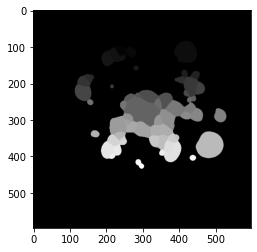

In [293]:
# Random walker segmentation¶
from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import skimage

I8_1 = (((binary_image6.astype(np.uint8) - binary_image6.astype(np.uint8).min()) / (binary_image6.astype(np.uint8).max() - binary_image6.astype(np.uint8).min())) * 255.9).astype(np.uint8)
bw = closing(image > (threshold_local(image, block_size,offset=0, method='mean')+20), square(3))
cleared = clear_border(bw)
# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
# markers = np.zeros(I8_1.shape, dtype=np.uint)
# markers[I8_1 == 0 ] = 0
# markers[I8_1 == 255 ] = 2
# markers = skimage.measure.label(I8_1)

labels = random_walker(image, label_image, beta=10, mode='bf')
plt.imshow(labels)

In [246]:
# testblock
image1 = np.where(image <= -1000, 0, image) 
image1 = (((image1 - image1.min()) / (image1.max() - image1.min())) * 255.9).astype(np.uint8)
markers = np.zeros(image1.shape, dtype=np.uint)
markers[image < np.percentile(image1, 5)] = 1
markers[image > np.percentile(image1, 95)] = 2

markers = np.zeros(binary_image1.shape, dtype=np.uint)
markers[binary_image6 == False ] = 1
markers[binary_image6 == True ] = 2

I8_1 = (((binary_image6.astype(np.uint8) - binary_image6.astype(np.uint8).min()) / (binary_image6.astype(np.uint8).max() - binary_image6.astype(np.uint8).min())) * 255.9).astype(np.uint8)
markers = np.zeros(I8_1.shape, dtype=np.uint)
markers[I8_1 == 0 ] = 0
markers[I8_1 == 1 ] = 2

I8_1 = (((binary_image6.astype(np.uint8) - binary_image6.astype(np.uint8).min()) / (binary_image6.astype(np.uint8).max() - binary_image6.astype(np.uint8).min())) * 255.9).astype(np.uint8)
# markers = np.zeros(I8_1.shape, dtype=np.uint)
# markers[I8_1 == 0 ] = 0
# markers[I8_1 == 255 ] = 2
markers = skimage.measure.label(I8_1)

<ipython-input-246-8982b8ef01ed>:12: RuntimeWarning: invalid value encountered in true_divide
  I8_1 = (((binary_image6.astype(np.uint8) - binary_image6.astype(np.uint8).min()) / (binary_image6.astype(np.uint8).max() - binary_image6.astype(np.uint8).min())) * 255.9).astype(np.uint8)
<ipython-input-246-8982b8ef01ed>:17: RuntimeWarning: invalid value encountered in true_divide
  I8_1 = (((binary_image6.astype(np.uint8) - binary_image6.astype(np.uint8).min()) / (binary_image6.astype(np.uint8).max() - binary_image6.astype(np.uint8).min())) * 255.9).astype(np.uint8)


In [ ]:
# filter the largest object
# labels = label(binary_image1)
# out = np.copy(binary_image1)
# component_sizes = np.bincount(binary_image1.ravel())
# too_small = component_sizes < 2000
# too_small_mask = too_small[binary_image1]
# out[too_small_mask] = 0
# return out

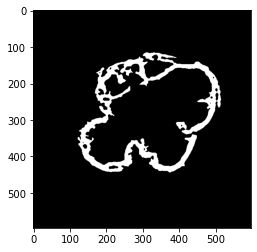

In [294]:
# filter the largest object
from skimage import morphology
binary_image2 = morphology.remove_small_objects(binary_image1, 2000)
plt.imshow(binary_image2)

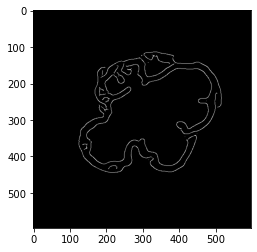

In [296]:
# edge
from skimage.feature import canny
binary_image3 = canny(binary_image2, sigma=6)
plt.imshow(binary_image3)

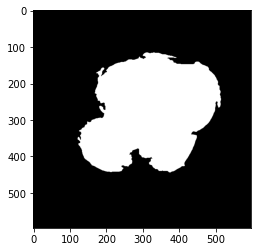

In [341]:
# fill holes
from scipy import ndimage as ndi
from skimage import io, morphology, img_as_bool, segmentation

out = ndi.distance_transform_edt(~binary_image2)
out = out < 0.05 * out.max()
out = morphology.skeletonize(out)
out = morphology.binary_dilation(out, morphology.selem.disk(1))
out = segmentation.clear_border(out)
out = out | binary_image2

fill_coins = ndi.binary_fill_holes(out)

plt.imshow(fill_coins)

(286.07723153234593, 319.0280230860163)


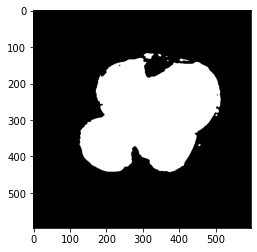

In [338]:
# find center
from skimage.measure import label, regionprops
from skimage import filters
threshold_value = filters.threshold_otsu(image)
labeled_foreground = (image > threshold_value).astype(int)
# labeled_foreground = ndi.binary_fill_holes(labeled_foreground0).astype(int)
# properties = regionprops(labeled_foreground, image)
properties = regionprops(labeled_foreground, labeled_foreground)
center_of_mass = properties[0].centroid
weighted_center_of_mass = properties[0].weighted_centroid

print(center_of_mass)
plt.imshow(labeled_foreground)

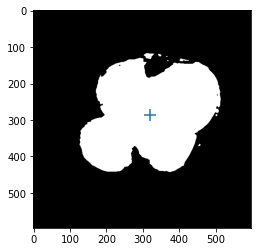

In [299]:
# show center
import matplotlib.pyplot as plt
from skimage.color import label2rgb

# a1 = np.where(a <= -1000, -999, a) 
# image255 = (((image - a1.min()) / (a1.max() - a1.min())) * 255.9).astype(np.uint8)
# colorized = label2rgb(labeled_foreground, image255, colors=['black', 'red'], alpha=0.1)
fig, ax = plt.subplots()
ax.imshow(labeled_foreground)
# Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
ax.scatter(center_of_mass[1], center_of_mass[0], s=160, c='C0', marker='+')
plt.show()

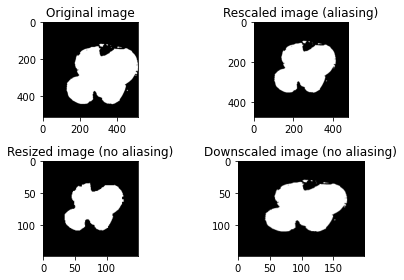

In [300]:
# resize image
from skimage.transform import rescale, resize, downscale_local_mean
image_rescaled = rescale(labeled_foreground, 0.80, anti_aliasing=False)
image_resized = resize(labeled_foreground, (labeled_foreground.shape[0] // 4, labeled_foreground.shape[1] // 4),
                       anti_aliasing=True)
image_downscaled = downscale_local_mean(labeled_foreground, (4, 3))

fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(labeled_foreground, cmap='gray')
ax[0].set_title("Original image")

ax[1].imshow(image_rescaled, cmap='gray')
ax[1].set_title("Rescaled image (aliasing)")

ax[2].imshow(image_resized, cmap='gray')
ax[2].set_title("Resized image (no aliasing)")

ax[3].imshow(image_downscaled, cmap='gray')
ax[3].set_title("Downscaled image (no aliasing)")

ax[0].set_xlim(0, 512)
ax[0].set_ylim(512, 0)
plt.tight_layout()
plt.show()

(228.6726470220332, 255.25381962438126)


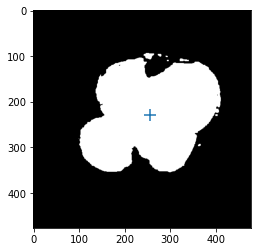

In [301]:
# center of rescale
from skimage import filters
image_rescaled[image_rescaled == image_rescaled.min()] = 0
image_rescaled[image_rescaled != image_rescaled.min()] = 1
properties1 = regionprops(image_rescaled.astype(int), image_rescaled)
center_of_mass1 = properties1[0].centroid
weighted_center_of_mass1 = properties1[0].weighted_centroid

print(center_of_mass1)

fig, ax = plt.subplots()
ax.imshow(image_rescaled)
# Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
ax.scatter(center_of_mass1[1], center_of_mass1[0], s=160, c='C0', marker='+')
plt.show()

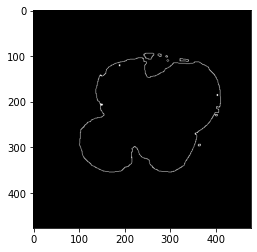

In [302]:
# edge of rescale
image_rescaled1 = label(image_rescaled)
image_rescaled2 = morphology.remove_small_objects(image_rescaled1, 200)
# image_rescaled2[image_rescaled2 != 0] = 1

image_rescaled3 = closing(canny(image_rescaled, sigma=1))

plt.imshow(image_rescaled3)

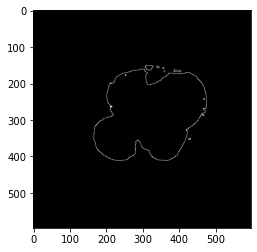

In [303]:
# overlay
import cv2
s_img = image_rescaled3
l_img = labeled_foreground.copy()
l_img[l_img != 0] =0
x_offset= round(center_of_mass[1] - center_of_mass1[1]).astype(int)
y_offset= round(center_of_mass[0] - center_of_mass1[0]).astype(int)
l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img

plt.imshow(l_img)

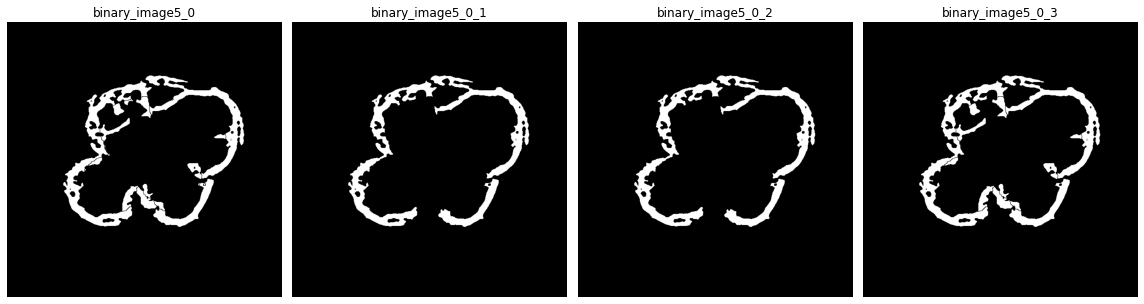

In [304]:
# selsct rescale range
binary_image5_0 = binary_image2 > l_img
binary_image5_0_1 = morphology.remove_small_objects(binary_image5_0, 1000)
binary_image5_0_2 = morphology.remove_small_objects(binary_image5_0, 2000)
binary_image5_0_3 = morphology.remove_small_objects(binary_image5_0, 100)

# plot results
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 6.4),
                                    sharex=True, sharey=True)
ax0.imshow(binary_image5_0, cmap='gray')
ax0.axis('off')
ax0.set_title('binary_image5_0')
ax1.imshow(binary_image5_0_1, cmap='gray')
ax1.axis('off')
ax1.set_title('binary_image5_0_1')
ax2.imshow(binary_image5_0_2, cmap='gray') # 'magma'
ax2.axis('off')
ax2.set_title('binary_image5_0_2')
ax3.imshow(binary_image5_0_3, cmap='gray')
ax3.axis('off')
ax3.set_title('binary_image5_0_3')

fig.tight_layout()
plt.show()

In [342]:
# define rescale
from scipy import ndimage as ndi
from skimage import io, morphology, img_as_bool, segmentation
from skimage import filters
from skimage.transform import rescale
from skimage.measure import regionprops
from skimage import morphology
from skimage.feature import canny
import cv2

def overlay_image_center(image, rescale, block_size, manoff, imageremovesize, removesize):
#     overlay image for cut inner off
    threshold_value = skimage.filters.threshold_otsu(image)
    labeled_foreground = (image > threshold_value)
#     labeled_backeground = np.where(skimage.morphology.remove_small_objects(labeled_foreground, imageremovesize) == 0,1,0)
    center_of_mass = skimage.measure.regionprops(labeled_foreground.astype(int), labeled_foreground.astype(int))[0].centroid
    image_rescaled = skimage.transform.rescale(labeled_foreground.astype(int), rescale, anti_aliasing=False)
    image_rescaled[image_rescaled == image_rescaled.min()] = 0
    image_rescaled[image_rescaled != image_rescaled.min()] = 1
    center_of_mass1 = skimage.measure.regionprops(image_rescaled.astype(int), image_rescaled)[0].centroid
    image_rescaled3 = skimage.morphology.closing(skimage.feature.canny(image_rescaled, sigma=1))
    s_img = image_rescaled3
    l_img = labeled_foreground.astype(int)
    l_img[l_img != 0] =0
    x_offset= round(center_of_mass[1] - center_of_mass1[1]).astype(int)
    y_offset= round(center_of_mass[0] - center_of_mass1[0]).astype(int)
    l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
#     process image
    binary_image1 = image > (skimage.filters.threshold_local(image, block_size,offset=0, method='mean')+manoff)
    binary_image2 = skimage.morphology.remove_small_objects(binary_image1, imageremovesize)
#     fill_coins = ndi.binary_fill_holes(binary_image1)
    binary_image5_0 = binary_image2 != l_img
    binary_image5_0_1 = skimage.morphology.remove_small_objects(binary_image5_0, removesize)
    # background
    out = ndi.distance_transform_edt(~binary_image2)
    out = out < 0.05 * out.max()
    out = morphology.skeletonize(out)
    out = morphology.binary_dilation(out, morphology.selem.disk(1))
    out = segmentation.clear_border(out)
    out = out | binary_image2
    labeled_backeground = np.where(ndi.binary_fill_holes(out) == 0,1,0)
    binary_image5_1 = labeled_backeground + binary_image5_0_1
    binary_image5_1[binary_image5_1 != 0] = 1
    return binary_image5_1

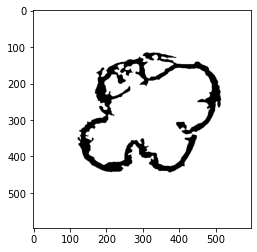

In [343]:
labeled_foreground = (image > threshold_value)
labeled_backeground = np.where(ndi.binary_fill_holes(binary_image2) == 0,1,0)
plt.imshow(labeled_backeground)

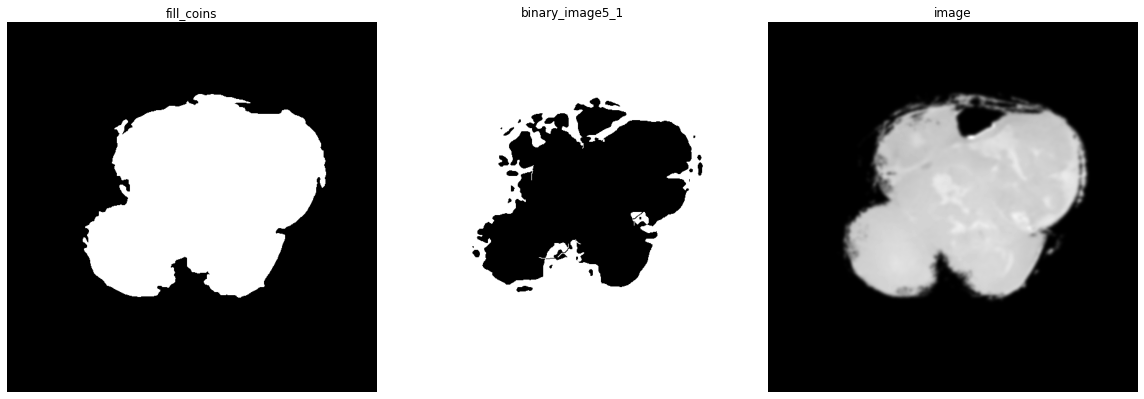

In [344]:
# test function
# image = a[:, :, 20].copy()
# image[0,0] = 1
binary_image5_1 = overlay_image_center(image=image, 
                                       rescale=0.6, 
                                       block_size=23, 
                                       manoff=20, 
                                       imageremovesize=2000, 
                                       removesize=2000)
# plt.imshow(binary_image5_1)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 6.4), sharex=True, sharey=True)
ax0.imshow(fill_coins, cmap='gray')
ax0.axis('off')
ax0.set_title('fill_coins')
ax1.imshow(binary_image5_1, cmap='gray')
ax1.axis('off')
ax1.set_title('binary_image5_1')
ax2.imshow(image, cmap='gray')
ax2.axis('off')
ax2.set_title('image')

fig.tight_layout()
plt.show()

In [345]:
# line method
indices = np.where(l_img == 1)
col1 = np.column_stack(indices)

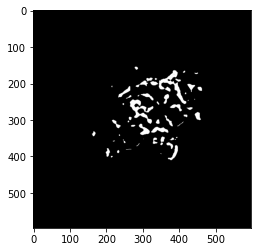

In [346]:
# remove the edge
# binary_image5 = binary_image1 != binary_image2
binary_image5 = binary_image1 > binary_image5_1
plt.imshow(binary_image5)

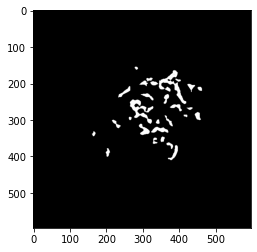

In [347]:
# remove small object
binary_image6 = morphology.remove_small_objects(binary_image5, 50)
plt.imshow(binary_image6)

In [231]:
# for loop
from PIL import Image
pathout = "./"+str(number1)+"_out2/"
result = np.empty([596, 596])
for i in range(a.shape[2]):
    image = a[:, :, i].copy()
    block_size = 23
    binary_image1 = image > (threshold_local(image, block_size,offset=0, method='mean')+20)
    binary_image6 = morphology.remove_small_objects(binary_image1, 2000)
#     binary_image5 = binary_image1 != binary_image2
#     binary_image6 = morphology.remove_small_objects(binary_image5, 50)
    I8_1 = (((binary_image6.astype(np.uint8) - binary_image6.astype(np.uint8).min()) / (binary_image6.astype(np.uint8).max() - binary_image6.astype(np.uint8).min())) * 255.9).astype(np.uint8)
    img1 = Image.fromarray(I8_1)
    img1.save(pathout+str(number1)+"_out2_rec00000"+str("{0:03}".format(i))+".bmp")
#     result = np.dstack((result, binary_image6))

# result.shape

<ipython-input-231-f678b4ae6839>:12: RuntimeWarning: invalid value encountered in true_divide
  I8_1 = (((binary_image6.astype(np.uint8) - binary_image6.astype(np.uint8).min()) / (binary_image6.astype(np.uint8).max() - binary_image6.astype(np.uint8).min())) * 255.9).astype(np.uint8)


In [232]:
from PIL import Image
pathout = "./"+str(number1)+"_out3/"
result = np.empty([596, 596])
for i in range(a.shape[2]):
    image = a[:, :, i].copy()
    block_size = 23
    binary_image1 = image > (threshold_local(image, block_size,offset=0, method='mean')+20)
    binary_image2 = morphology.dilation(binary_image1, morphology.disk(radius=5))
    fill_coins = ndi.binary_fill_holes(binary_image2)
    binary_image3 = canny(fill_coins, sigma=1)
    binary_image4 = morphology.dilation(binary_image3, morphology.disk(radius=25))
    binary_image5 = binary_image1 > binary_image4
    binary_image6 = morphology.remove_small_objects(binary_image5, 50)
    I8_1 = (((binary_image6.astype(np.uint8) - binary_image6.astype(np.uint8).min()) / (binary_image6.astype(np.uint8).max() - binary_image6.astype(np.uint8).min())) * 255.9).astype(np.uint8)
    img1 = Image.fromarray(I8_1)
    img1.save(pathout+str(number1)+"_out3_rec00000"+str("{0:03}".format(i))+".bmp")
#     result = np.dstack((result, binary_image6))

# result.shape

<ipython-input-232-85b140ce5e15>:14: RuntimeWarning: invalid value encountered in true_divide
  I8_1 = (((binary_image6.astype(np.uint8) - binary_image6.astype(np.uint8).min()) / (binary_image6.astype(np.uint8).max() - binary_image6.astype(np.uint8).min())) * 255.9).astype(np.uint8)


In [ ]:
from PIL import Image
pathout = "./"+str(number1)+"_out4/"
result = np.empty([596, 596])
for i in range(a.shape[2]):
    image = a[:, :, i].copy()
    image[0,0] = 1
    block_size = 23
    binary_image1 = image > (threshold_local(image, block_size,offset=0, method='mean')+20)
    binary_image5_1 = overlay_image_center(image=image, 
                                       rescale=0.6, 
                                       block_size=23, 
                                       manoff=20, 
                                       imageremovesize=2000, 
                                       removesize=2000)
    binary_image5 = binary_image1 > binary_image5_1
    binary_image6 = morphology.remove_small_objects(binary_image5, 50)
    I8_1 = (((binary_image6.astype(np.uint8) - binary_image6.astype(np.uint8).min()) / (binary_image6.astype(np.uint8).max() - binary_image6.astype(np.uint8).min())) * 255.9).astype(np.uint8)
    img1 = Image.fromarray(I8_1)
    img1.save(pathout+str(number1)+"_out4_rec00000"+str("{0:03}".format(i))+".bmp")